In [1]:
# Check version
import srs
print(f"SRS Version: {srs.__version__}")
if srs.__version__ < "0.1.5":
    print("WARNING: Please restart the kernel to load the latest version!")

SRS Version: 0.1.5


# Symbolic Resonance Solver - Interactive Demo

This notebook demonstrates the **symbolic-resonance-solver** package, a quantum-inspired algorithm for solving NP-complete problems.

## Installation

```bash
pip install --force-reinstall symbolic-resonance-solver matplotlib seaborn jupyter
```

**Note:** If you are running this in a notebook and have just installed or updated the package, you may need to **restart the kernel** for changes to take effect.

In [2]:
%pip install symbolic-resonance-solver matplotlib seaborn jupyter

# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

# Import the solver
from srs import SRSSolver, Problem, SRSConfig, SATClause

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## 1. Simple SAT Problem

Let's start with a simple 3-SAT problem with 5 variables.

In [3]:
# Create a 3-SAT problem
# Variables: x0, x1, x2, x3, x4
clauses = [
    [(0, True), (1, False), (2, True)],   # (x0 ∨ ¬x1 ∨ x2)
    [(1, True), (3, True), (4, False)],   # (x1 ∨ x3 ∨ ¬x4)
    [(0, False), (2, False), (3, True)],  # (¬x0 ∨ ¬x2 ∨ x3)
    [(2, True), (3, False), (4, True)],   # (x2 ∨ ¬x3 ∨ x4)
]

# Create constraint clauses
sat_clauses = [SATClause(clause) for clause in clauses]

# Create problem
problem = Problem(
    num_variables=5,
    constraints=sat_clauses,
    name="Simple 3-SAT"
)

print(f"Problem: {problem.name}")
print(f"Variables: {problem.num_variables}")
print(f"Clauses: {len(clauses)}")

Problem: Simple 3-SAT
Variables: 5
Clauses: 4


### Solve the Problem

In [4]:
# Create solver
solver = SRSSolver()

# Solve
solution = problem.solve(solver, telemetry=True)

# Display results
print(f"\n{'='*60}")
print(f"Solution Found: {solution.feasible}")
print(f"{'='*60}")

if solution.feasible:
    print(f"\nVariable Assignment:")
    for i, val in enumerate(solution.assignment):
        print(f"  x{i} = {val}")
    
    print(f"\nQuality Metrics:")
    print(f"  Objective Value: {solution.objective:.6f}")
    print(f"  Constraint Violations: {(solution.total - solution.satisfied)}")
    print(f"  Iterations: {solution.found_at}")
    print(f"  Solve Time: {solution.compute_time:.4f}s")


Solution Found: True

Variable Assignment:
  x0 = 0
  x1 = 0
  x2 = 1
  x3 = 1
  x4 = 1

Quality Metrics:
  Objective Value: 0.000000
  Constraint Violations: 0
  Iterations: 1
  Solve Time: 0.0031s


## 2. Visualizing Convergence

Let's examine how the solver converges to a solution.

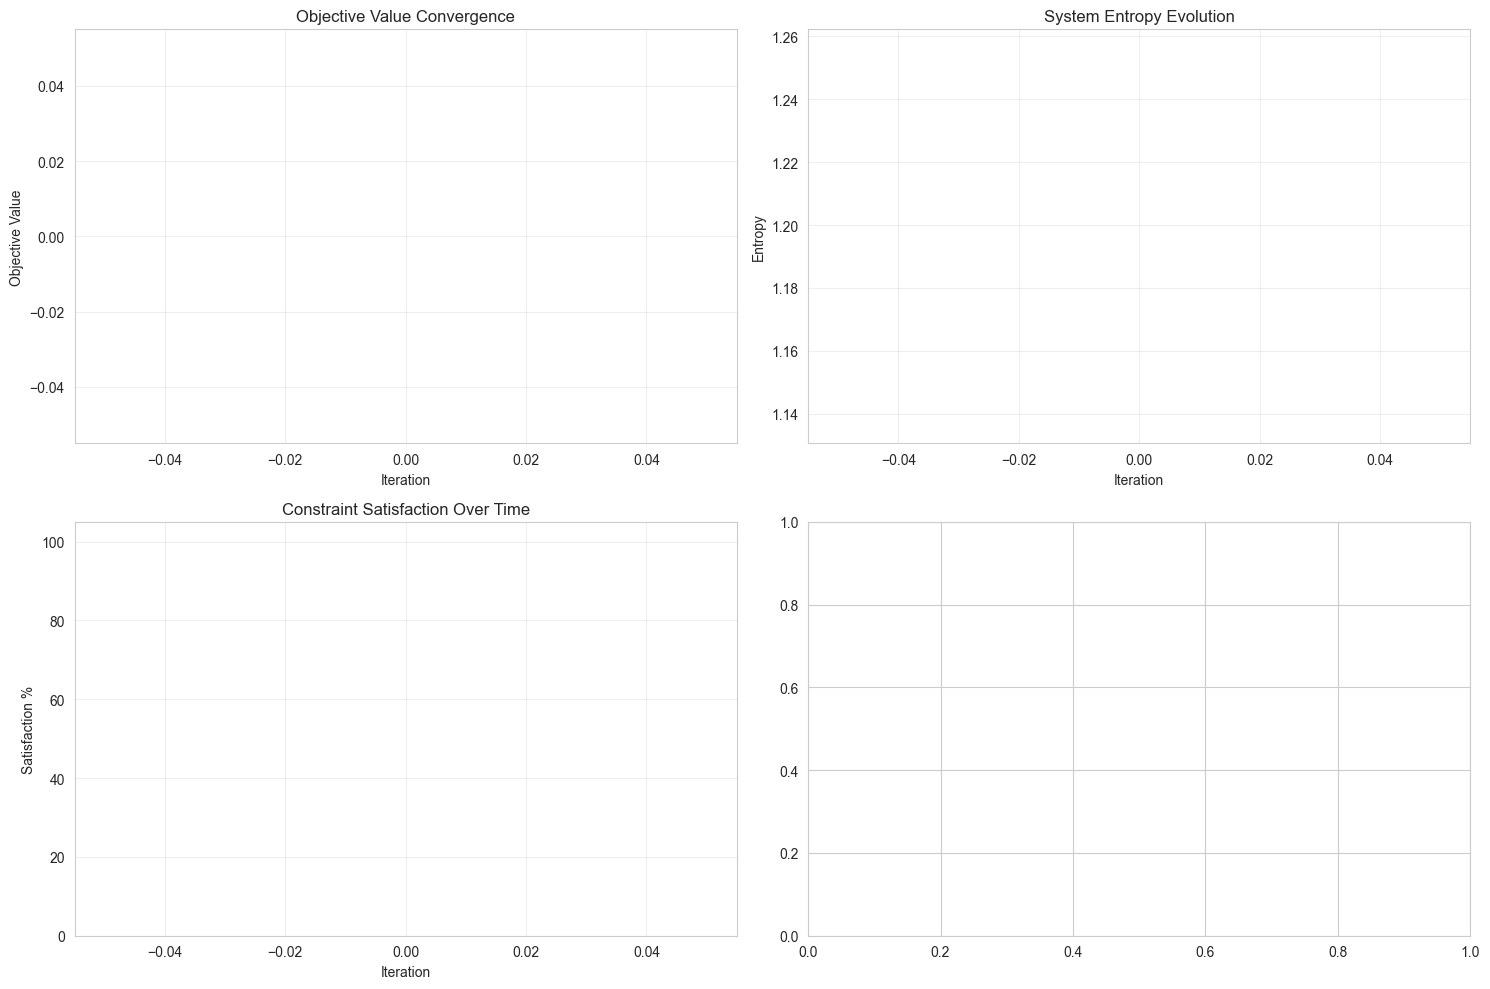


Convergence Statistics:
  Initial Entropy: 1.1964
  Final Entropy: 1.1964
  Entropy Reduction: 0.0000
  Final Satisfaction: 100.00%


In [5]:
# Extract telemetry
telemetry = solution.telemetry
iterations = range(len(telemetry.convergence_history))

# Create convergence plot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Objective Value Convergence
axes[0, 0].plot(iterations, telemetry.convergence_history, 'b-', linewidth=2)
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('Objective Value')
axes[0, 0].set_title('Objective Value Convergence')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Entropy Evolution
axes[0, 1].plot(iterations, telemetry.entropy_history, 'r-', linewidth=2)
axes[0, 1].set_xlabel('Iteration')
axes[0, 1].set_ylabel('Entropy')
axes[0, 1].set_title('System Entropy Evolution')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Constraint Satisfaction
satisfaction = [(1.0 - v) * 100 for v in telemetry.violation_history]
axes[1, 0].plot(iterations, satisfaction, 'g-', linewidth=2)
axes[1, 0].set_xlabel('Iteration')
axes[1, 0].set_ylabel('Satisfaction %')
axes[1, 0].set_title('Constraint Satisfaction Over Time')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim([0, 105])

# Plot 4: Convergence Rate
if len(telemetry.convergence_history) > 1:
    conv_diff = np.diff(telemetry.convergence_history)
    axes[1, 1].plot(iterations[1:], conv_diff, 'purple', linewidth=2)
    axes[1, 1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[1, 1].set_xlabel('Iteration')
    axes[1, 1].set_ylabel('Δ Objective')
    axes[1, 1].set_title('Convergence Rate (Change per Iteration)')
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nConvergence Statistics:")
print(f"  Initial Entropy: {telemetry.entropy_history[0]:.4f}")
print(f"  Final Entropy: {telemetry.entropy_history[-1]:.4f}")
print(f"  Entropy Reduction: {(telemetry.entropy_history[0] - telemetry.entropy_history[-1]):.4f}")
print(f"  Final Satisfaction: {satisfaction[-1]:.2f}%")

## 3. Scaling Analysis

Let's test how the solver scales with problem size.

In [6]:
def generate_random_3sat(num_vars, num_clauses, seed=42):
    """Generate a random 3-SAT problem."""
    np.random.seed(seed)
    sat_clauses = []
    
    for _ in range(num_clauses):
        # Pick 3 random variables
        vars = np.random.choice(num_vars, size=3, replace=False)
        # Random polarities (False means not negated, True means negated)
        polarities = np.random.choice([True, False], size=3)
        clause = [(int(v), bool(p)) for v, p in zip(vars, polarities)]
        sat_clauses.append(SATClause(clause))
    
    return sat_clauses

# Test different problem sizes
sizes = [5, 8, 10, 12, 15]
results = []

print("Testing solver scalability...\n")

for size in sizes:
    # Create problem (using 4.3 * n clauses, typical for 3-SAT)
    num_clauses = int(4.3 * size)
    clauses = generate_random_3sat(size, num_clauses)
    problem = Problem(
        num_variables=size,
        constraints=clauses,
        name=f"3-SAT-{size}"
    )
    
    # Solve
    solver = SRSSolver()
    solution = problem.solve(solver, telemetry=True)
    
    # Record results
    satisfaction = (1.0 - solution.telemetry.violation_history[-1]) * 100
    results.append({
        'size': size,
        'clauses': num_clauses,
        'time': solution.compute_time,
        'iterations': solution.found_at,
        'satisfaction': satisfaction,
        'solved': solution.feasible
    })
    
    print(f"Size {size:2d}: {solution.compute_time:6.3f}s, "
          f"{solution.found_at:4d} iters, "
          f"{satisfaction:5.1f}% satisfied")

print("\nDone!")

Testing solver scalability...

Size  5:  0.003s,    1 iters, 100.0% satisfied
Size  8:  0.003s,    1 iters, 100.0% satisfied
Size 10:  0.003s,    1 iters, 100.0% satisfied
Size 12: 25.887s,    0 iters,  96.1% satisfied
Size 15: 30.294s,    0 iters,  95.3% satisfied

Done!


### Visualize Scaling Results

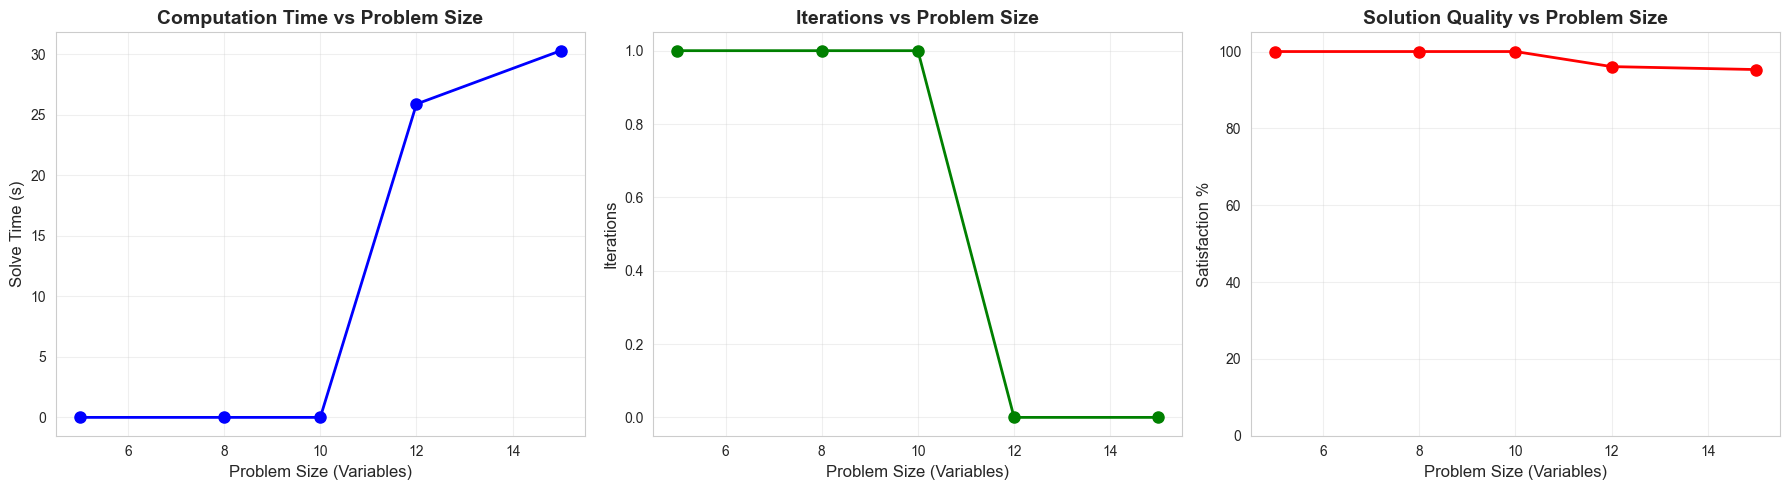

In [7]:
# Extract data
sizes = [r['size'] for r in results]
times = [r['time'] for r in results]
iterations = [r['iterations'] for r in results]
satisfactions = [r['satisfaction'] for r in results]

# Create scaling plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Time Scaling
axes[0].plot(sizes, times, 'o-', linewidth=2, markersize=8, color='blue')
axes[0].set_xlabel('Problem Size (Variables)', fontsize=12)
axes[0].set_ylabel('Solve Time (s)', fontsize=12)
axes[0].set_title('Computation Time vs Problem Size', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Plot 2: Iteration Scaling
axes[1].plot(sizes, iterations, 'o-', linewidth=2, markersize=8, color='green')
axes[1].set_xlabel('Problem Size (Variables)', fontsize=12)
axes[1].set_ylabel('Iterations', fontsize=12)
axes[1].set_title('Iterations vs Problem Size', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Plot 3: Solution Quality
axes[2].plot(sizes, satisfactions, 'o-', linewidth=2, markersize=8, color='red')
axes[2].set_xlabel('Problem Size (Variables)', fontsize=12)
axes[2].set_ylabel('Satisfaction %', fontsize=12)
axes[2].set_title('Solution Quality vs Problem Size', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].set_ylim([0, 105])

plt.tight_layout()
plt.show()

## 4. Configuration Tuning

The solver can be configured with various parameters.

In [8]:
# Create a moderately difficult problem
clauses = generate_random_3sat(10, 43)
problem = Problem(
    num_variables=10,
    constraints=clauses,
    name="Tuning Test"
)

# Test different configurations
configs = [
    {"name": "Default", "max_iterations": 1000},
    {"name": "More Particles", "max_iterations": 1000, "particle_count": 100},
    {"name": "Higher Precision", "max_iterations": 2000, "plateau_threshold": 1e-8},
    {"name": "Quantum Focus", "max_iterations": 1000, "quantum_factor": 0.3},
]

config_results = []

print("Testing different configurations...\n")

for cfg in configs:
    cfg_copy = cfg.copy()
    name = cfg_copy.pop("name")
    
    # Create custom config
    config = SRSConfig(**cfg_copy)
    
    # Solve
    solver = SRSSolver(config=config)
    solution = problem.solve(solver, telemetry=True)
    
    satisfaction = (1.0 - solution.telemetry.violation_history[-1]) * 100
    
    config_results.append({
        'name': name,
        'time': solution.compute_time,
        'iterations': solution.found_at,
        'satisfaction': satisfaction
    })
    
    print(f"{name:20s}: {solution.compute_time:6.3f}s, "
          f"{solution.found_at:4d} iters, {satisfaction:5.1f}%")

print("\nDone!")

Testing different configurations...

Default             :  0.004s,    1 iters, 100.0%
More Particles      :  9.208s,    0 iters,  97.7%
Higher Precision    :  9.265s,    0 iters,  97.7%
Quantum Focus       :  4.594s,    0 iters,  97.7%

Done!


### Compare Configurations

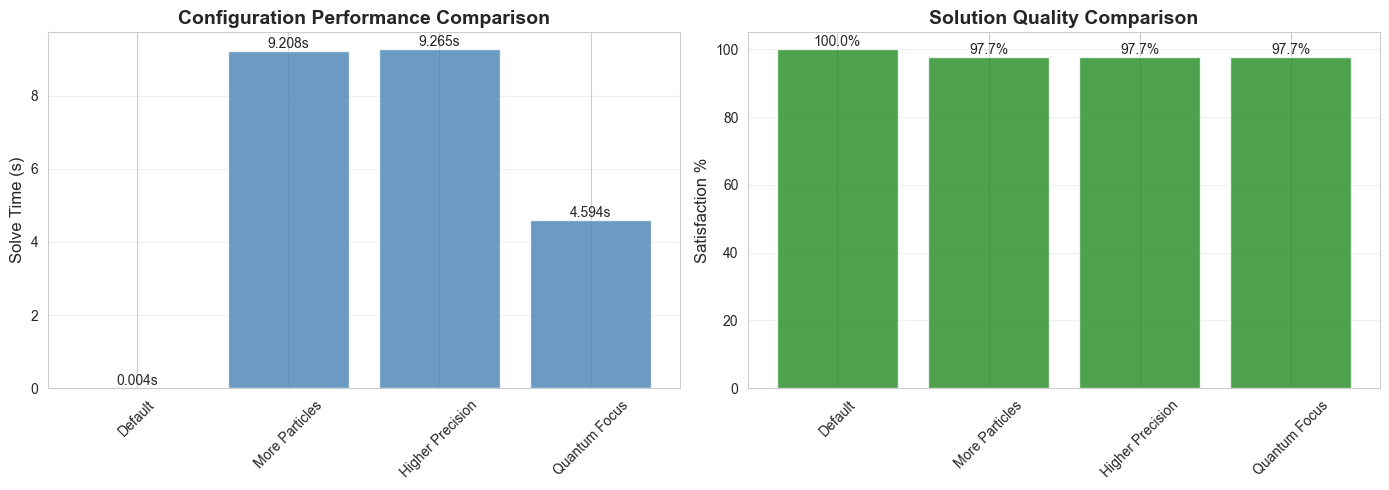

In [9]:
# Extract data
names = [r['name'] for r in config_results]
times = [r['time'] for r in config_results]
satisfactions = [r['satisfaction'] for r in config_results]

# Create comparison plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Time Comparison
bars1 = axes[0].bar(names, times, color='steelblue', alpha=0.8)
axes[0].set_ylabel('Solve Time (s)', fontsize=12)
axes[0].set_title('Configuration Performance Comparison', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}s', ha='center', va='bottom', fontsize=10)

# Plot 2: Quality Comparison
bars2 = axes[1].bar(names, satisfactions, color='forestgreen', alpha=0.8)
axes[1].set_ylabel('Satisfaction %', fontsize=12)
axes[1].set_title('Solution Quality Comparison', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_ylim([0, 105])
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## 5. Advanced: Entropy Dynamics

The solver uses quantum-inspired entropy dynamics. Let's visualize this.

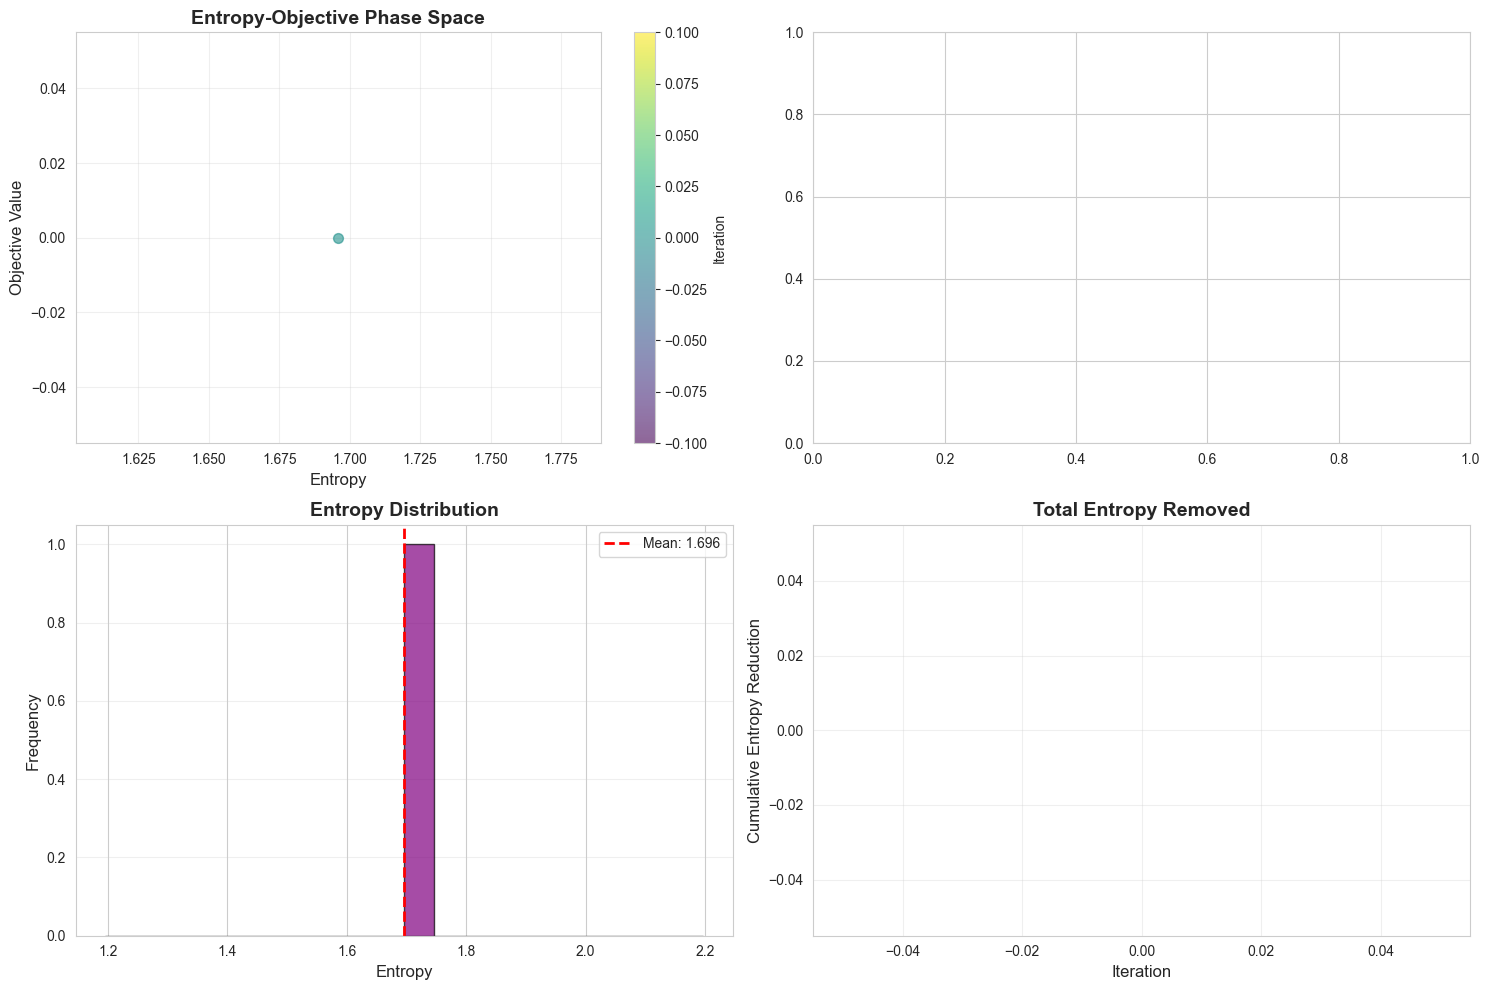


Entropy Statistics:
  Initial: 1.6960
  Final: 1.6960
  Mean: 1.6960
  Std Dev: 0.0000
  Total Reduction: 0.0000
  Reduction %: 0.00%


In [10]:
# Solve a problem and extract detailed telemetry
clauses = generate_random_3sat(8, 34)
problem = Problem(
    num_variables=8,
    constraints=clauses,
    name="Entropy Analysis"
)

solver = SRSSolver()
solution = problem.solve(solver, telemetry=True)

# Analyze entropy dynamics
telemetry = solution.telemetry
entropy = np.array(telemetry.entropy_history)
convergence = np.array(telemetry.convergence_history)

# Create detailed entropy analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Entropy vs Objective
axes[0, 0].scatter(entropy, convergence, c=range(len(entropy)), 
                   cmap='viridis', alpha=0.6, s=50)
axes[0, 0].set_xlabel('Entropy', fontsize=12)
axes[0, 0].set_ylabel('Objective Value', fontsize=12)
axes[0, 0].set_title('Entropy-Objective Phase Space', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
cbar = plt.colorbar(axes[0, 0].collections[0], ax=axes[0, 0])
cbar.set_label('Iteration', fontsize=10)

# Plot 2: Entropy Derivative
if len(entropy) > 1:
    entropy_deriv = np.diff(entropy)
    axes[0, 1].plot(entropy_deriv, linewidth=2, color='red')
    axes[0, 1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[0, 1].set_xlabel('Iteration', fontsize=12)
    axes[0, 1].set_ylabel('Δ Entropy', fontsize=12)
    axes[0, 1].set_title('Entropy Change Rate', fontsize=14, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Entropy Distribution
axes[1, 0].hist(entropy, bins=20, color='purple', alpha=0.7, edgecolor='black')
axes[1, 0].axvline(np.mean(entropy), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {np.mean(entropy):.3f}')
axes[1, 0].set_xlabel('Entropy', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Entropy Distribution', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: Cumulative Entropy Reduction
cumulative_reduction = entropy[0] - entropy
axes[1, 1].plot(cumulative_reduction, linewidth=2, color='green')
axes[1, 1].fill_between(range(len(cumulative_reduction)), 
                         cumulative_reduction, alpha=0.3, color='green')
axes[1, 1].set_xlabel('Iteration', fontsize=12)
axes[1, 1].set_ylabel('Cumulative Entropy Reduction', fontsize=12)
axes[1, 1].set_title('Total Entropy Removed', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nEntropy Statistics:")
print(f"  Initial: {entropy[0]:.4f}")
print(f"  Final: {entropy[-1]:.4f}")
print(f"  Mean: {np.mean(entropy):.4f}")
print(f"  Std Dev: {np.std(entropy):.4f}")
print(f"  Total Reduction: {entropy[0] - entropy[-1]:.4f}")
print(f"  Reduction %: {((entropy[0] - entropy[-1]) / entropy[0] * 100):.2f}%")

## Conclusion

This notebook demonstrated:

1. ✅ **Basic Usage** - How to create and solve SAT problems
2. ✅ **Convergence Analysis** - Visualizing solver behavior over time
3. ✅ **Scalability** - Performance across different problem sizes
4. ✅ **Configuration** - Tuning solver parameters for optimal performance
5. ✅ **Entropy Dynamics** - Understanding the quantum-inspired algorithm

### Learn More

- **GitHub:** https://github.com/sschepis/np-complete-solver
- **PyPI:** https://pypi.org/project/symbolic-resonance-solver/
- **Documentation:** See README.md and SRS_PAPER.md

### Author

Sebastian Schepis (sschepis@gmail.com)

### License

Custom Restricted Use License - See LICENSE file for details.